In [60]:
import pandas as pd

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier



In [61]:
df = pd.read_csv('../data/dataset_small.csv')

In [62]:
df["phishing"].value_counts()

1    30647
0    27998
Name: phishing, dtype: int64

## Prep dataset

In [63]:
# sample 10k rows from each class in phishing column
df = df.groupby('phishing', group_keys=False).apply(lambda x: x.sample(min(len(x), 10000)))

# create X and y
X = df.drop('phishing', axis=1)
y = df['phishing']

# remove all negative values in X
X[X < 0] = 0

# select the 50 most powerful features
X_new = SelectKBest(chi2, k=50).fit_transform(X, y)

# print the most powerful features
X.columns[SelectKBest(chi2, k=50).fit(X, y).get_support()].tolist()

# remove features from X which are not in X_new
X = X[X.columns[SelectKBest(chi2, k=50).fit(X, y).get_support()].tolist()]

# split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Naive Bayes

In [64]:
# train NB
clf = MultinomialNB()
clf.fit(X_train, y_train)

# predict the test set
y_pred = clf.predict(X_test)

# print F1
print("F1 score: ", accuracy_score(y_test, y_pred))

F1 score:  0.66375


## SVC

In [65]:
# train SVC
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

# predict the test set
y_pred = clf.predict(X_test)

# print F1
print("F1 score: ", accuracy_score(y_test, y_pred))

## Random Forest

In [59]:
# train random forest
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# predict the test set
y_pred = clf.predict(X_test)

# print F1
print("F1 score: ", accuracy_score(y_test, y_pred))

F1 score:  0.94275


## XGBoost

In [51]:
# train XGBoost
clf = XGBClassifier()
clf.fit(X_train, y_train)

# predict the test set
y_pred = clf.predict(X_test)

# print F1
print("F1 score: ", accuracy_score(y_test, y_pred))

# print classification report
print(classification_report(y_test, y_pred))

F1 score:  0.94325
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1986
           1       0.94      0.95      0.94      2014

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



In [42]:
# perform cross validation

scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))



Accuracy: 0.95 (+/- 0.00)


AUC: 0.99


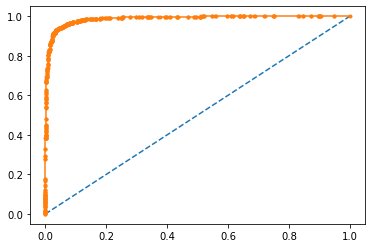

In [58]:
# create a ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# predict probabilities
probs = clf.predict_proba(X_test)

# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')